AutoEncoder

In [1]:
from __future__ import print_function
import argparse
import torch
import torch.utils.data
from torch import nn, optim
from torch.nn import functional as F
from torchvision import datasets, transforms
from torchvision.utils import save_image
import matplotlib.pyplot as plt

batchsize = 128
epochs=10
loginterval=10
cuda = torch.cuda.is_available()

SEED = 1
torch.manual_seed(SEED)

device = torch.device("cuda" if cuda else "cpu")

kwargs = {'num_workers': 4, 'pin_memory': True} if cuda else {}
train_loader = torch.utils.data.DataLoader(
    datasets.MNIST('../data', train=True, download=True,
                   transform=transforms.ToTensor()),
    batch_size=batchsize, shuffle=True, **kwargs)
test_loader = torch.utils.data.DataLoader(
    datasets.MNIST('../data', train=False, transform=transforms.ToTensor()),
    batch_size=batchsize, shuffle=True, **kwargs)

In [2]:
class AE(nn.Module):
    def __init__(self):
        super(AE, self).__init__()

        # create using nn.Sequential()
        # encoder :FC (784 -> 400), RELU activation; FC (400, 20)
        # decoder :FC (20 -> 400), RELU activation; FC (400, 784)

        self.encoder = nn.Sequential(nn.Linear(784,400),nn.ReLU(),nn.Linear(400,20))


        self.decoder = nn.Sequential(nn.Linear(20,400),nn.ReLU(),nn.Linear(400,784))


    def encode(self,x):
        return self.encoder(x)
        
    def decode(self,x):
        return torch.sigmoid(self.decoder(x))
        
    def forward(self, x):
        # complete: xview = x.view(...)
        x = x.view((-1, 784))
        z = self.encode(x)
        return self.decode(z)

model = AE()
optimizer = optim.Adam(model.parameters(), lr=1e-3)

In [3]:
def loss_function(recon_batch, x):
    #compute bce as the binary cross entropy across the batch as a sum
    bce = nn.BCELoss(size_average=False)
    return bce(recon_batch, x)


In [4]:
losses = []
def train(epoch):
    model.train()
    train_loss = 0
    for batch_idx, (data, _) in enumerate(train_loader):
        data = data.to(device)
        optimizer.zero_grad()
        recon_batch = model(data)
        loss = loss_function(recon_batch, data.view(-1, 784))
        losses.append(loss.cpu().item())
        loss.backward()
        train_loss += loss.item()
        optimizer.step()
        if batch_idx % loginterval == 0:
            print('\r Train Epoch: {} [{}/{} ({:.0f}%)]\tLoss: {:.1f}'.format(
                epoch, batch_idx * len(data), len(train_loader.dataset),
                100. * batch_idx / len(train_loader),
                loss.item() / len(data)), end='')

    print(' Average loss: {:.1f}'.format(
          train_loss / len(train_loader.dataset)), end='')

In [5]:
def test(epoch):
    model.eval()
    test_loss = 0
    with torch.no_grad():
        for i, (data, _) in enumerate(test_loader):
            data = data.to(device)
            recon_batch = model(data)
            test_loss += loss_function(recon_batch, data.view(-1, 784))

            if i == 0:
                n = min(data.size(0), 8)
                comparison = torch.cat([data[:n],
                                      recon_batch.view(batchsize, 1, 28, 28)[:n]])
                save_image(comparison.cpu(),
                         '/home/aberniga/apprentissage_profond/results/reconstruction_' + str(epoch) + '.png', nrow=n)

    test_loss /= len(test_loader.dataset)
    print(' Test loss: {:.1f}'.format(test_loss))

In [6]:
for epoch in range(1, epochs + 1):
    train(epoch)
    test(epoch)
    with torch.no_grad():
     sample = torch.randn(64, 20).to(device)
     sample = model.decode(sample).cpu()
     save_image(sample.view(64, 1, 28, 28), '/home/aberniga/apprentissage_profond/results/sample_' + str(epoch) + '.png')

/opt/miniconda/lib/python3.6/site-packages/torch/nn/functional.py:52: UserWarning: size_average and reduce args will be deprecated, please use reduction='sum' instead.
  warnings.warn(warning.format(ret))


 Train Epoch: 1 [58880/60000 (98%)]	Loss: 90.79 Average loss: 132.0 Test loss: 89.0
 Train Epoch: 2 [58880/60000 (98%)]	Loss: 84.5 Average loss: 83.4 Test loss: 78.1
 Train Epoch: 3 [58880/60000 (98%)]	Loss: 76.9 Average loss: 77.0 Test loss: 74.5
 Train Epoch: 4 [58880/60000 (98%)]	Loss: 76.2 Average loss: 74.2 Test loss: 72.5
 Train Epoch: 5 [58880/60000 (98%)]	Loss: 73.4 Average loss: 72.4 Test loss: 71.4
 Train Epoch: 6 [58880/60000 (98%)]	Loss: 69.6 Average loss: 71.1 Test loss: 70.3
 Train Epoch: 7 [58880/60000 (98%)]	Loss: 69.8 Average loss: 70.2 Test loss: 69.5
 Train Epoch: 8 [58880/60000 (98%)]	Loss: 71.2 Average loss: 69.4 Test loss: 68.8
 Train Epoch: 9 [58880/60000 (98%)]	Loss: 68.4 Average loss: 68.8 Test loss: 68.5
 Train Epoch: 10 [58880/60000 (98%)]	Loss: 69.2 Average loss: 68.3 Test loss: 68.1


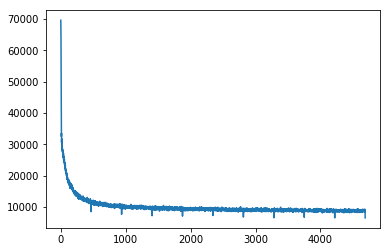

In [7]:
#plot losses
plt.plot(losses)